# AutoEncoder

Build a 2 layers auto-encoder with TensorFlow to compress images to a lower latent space and then reconstruct them.

### Overview

<img src="../../img/ae1.jpeg" width="500px">

<img src="../../img/ae2.png" width="500px">

### Dataset

- use some image from **cat and dog** dataset [(source)](https://www.kaggle.com/c/dogs-vs-cats/data) (dataset/cat200200.jpg)

### Setup

In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir
from PIL import Image

### Import data

In [28]:
dataset_path = '../../dataset/catdog/train/'

list_file = listdir(dataset_path)[1:3501]
filepath = [dataset_path+name for name in list_file]
print('Number of dataset :',len(filepath))

Number of dataset : 3500


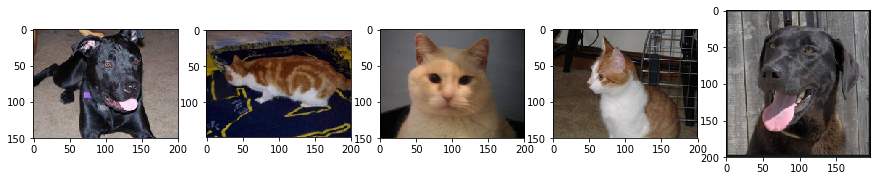

In [29]:
i = 1
plt.figure(figsize = (15,8))

for file in filepath[20:25]:
    img = Image.open(file)
    img.thumbnail((200, 200), Image.ANTIALIAS) # resizes image in-place
    plt.subplot(1,5,i)
    plt.imshow(img)
    i = i + 1
plt.show()

## Convolutional Autoencoder

In [30]:
# number of parameter จะต้องลดลงพอจนเอาไปใช้ต่อได้ง่ายๆ ตามวัตถุประสงค์ของ model นี้
print(320*320*3)
print(80*80*8)  # 4 stride
print(20*20*16) # 4 stride

307200
51200
6400


In [31]:
# parameter
image_size   = 320 # width and height of image
num_channels = 3   # RGB = 3
batch_size   = 10
patch_size   = 5
depth        = 8
depth2       = 16

In [32]:
graph = tf.Graph()

with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))

    # Variables.
    # - encoder layars     
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    
    # - decoder layars     
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth2], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer4_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer4_biases = tf.Variable(tf.zeros([num_channels]))
    
    # Building the encoder
    def encoder(data):
        # convolution        
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 4, 4, 1], padding='SAME')
        hidden1 = tf.nn.relu(conv1 + layer1_biases)
        print("Conv1 :", hidden1.shape)
        conv2 = tf.nn.conv2d(hidden1, layer2_weights, [1, 4, 4, 1], padding='SAME')
        hidden2 = tf.nn.relu(conv2 + layer2_biases)
        print("Conv2 :", hidden2.shape)
        return hidden1, hidden2

    # Building the decoder
    def decoder(hidden1, hidden2):
        # deconvolution
        output_shape3 = hidden1.shape
        conv3 = tf.nn.conv2d_transpose(hidden2, layer3_weights, output_shape3, [1, 4, 4, 1], padding='SAME')
        hidden3 = tf.nn.relu(conv3 + layer3_biases)
        print("Conv3 :", hidden3.shape)
        output_shape4 = tf_train_dataset.shape
        conv4 = tf.nn.conv2d_transpose(hidden3, layer4_weights, output_shape4, [1, 4, 4, 1], padding='SAME')
        output = tf.nn.relu(conv4 + layer4_biases)
        print("Output Image :", output.shape)
        return output
    
    # Construct model
    encoder_layer1, encoder_layer2 = encoder(tf_train_dataset)
    decoder_op = decoder(encoder_layer1, encoder_layer2)
    
    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = tf_train_dataset
    
    loss = tf.reduce_mean(tf.square(tf.subtract(y_pred, y_true)))
    optimizer = tf.train.AdamOptimizer().minimize(loss)   

Conv1 : (10, 80, 80, 8)
Conv2 : (10, 20, 20, 16)
Conv3 : (10, 80, 80, 8)
Output Image : (10, 320, 320, 3)


## Training Model

In [33]:
def jpeg_to_rgb(filename):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_resized = tf.image.resize_images(image_decoded, [image_size, image_size])
    return image_resized

In [34]:
num_steps  = 1001

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print('Initialized')
    
    # TF graph input    
    paths = tf.constant(filepath)
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(jpeg_to_rgb)
    
    iterator = dataset.batch(batch_size)
    iterator = iterator.make_one_shot_iterator()
    X = iterator.get_next()
    
    step = 0
    while step < num_steps:
        try:
            feed_dict = {tf_train_dataset: X.eval()}
            _, cost, predictions, answers = sess.run([optimizer, loss, y_pred, y_true], feed_dict=feed_dict)
            
            if (step % 50 == 0):
                print('Minibatch loss at step %d: %f' % (step, cost) )

            step = step + 1

        except tf.errors.OutOfRangeError:
            print("End of dataset.")
            break

Initialized
Minibatch loss at step 0: 23547.128906
Minibatch loss at step 50: 4467.645996
Minibatch loss at step 100: 1419.659546
Minibatch loss at step 150: 1200.413330
Minibatch loss at step 200: 828.069824
Minibatch loss at step 250: 1045.351318
Minibatch loss at step 300: 812.282471
End of dataset.


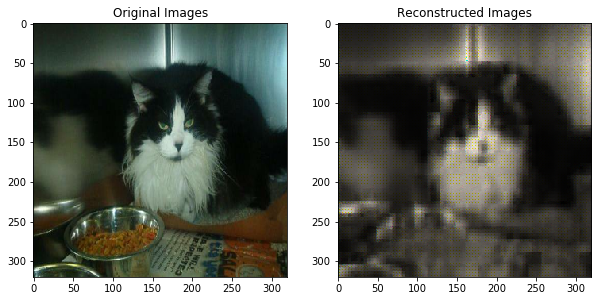

In [37]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(answers[5]/255)
plt.title('Original Images')
plt.subplot(1,2,2)
plt.imshow(predictions[5]/255)
plt.title('Reconstructed Images')
plt.show()

## Decode JPEG to R, G, B matrix

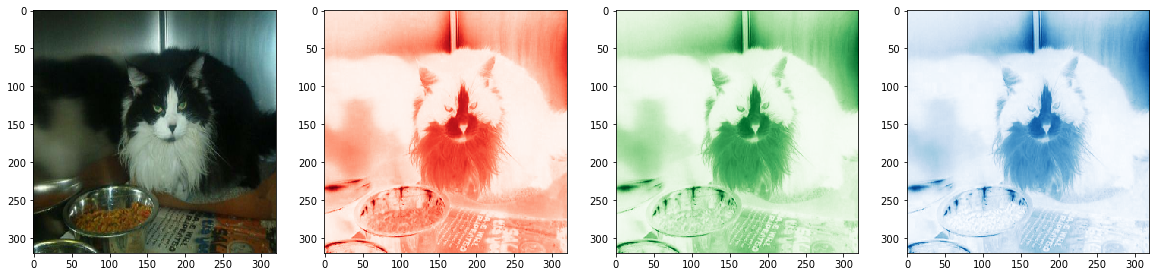

In [38]:
plt.figure(figsize = (20,10))
plt.subplot(1,4,1)
plt.imshow(answers[5]/255)
plt.subplot(1,4,2)
plt.imshow(answers[5][:,:,0],cmap="Reds")
plt.subplot(1,4,3)
plt.imshow(answers[5][:,:,1],cmap="Greens")
plt.subplot(1,4,4)
plt.imshow(answers[5][:,:,2],cmap="Blues")
plt.show()